In [201]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.sparse.linalg
from scipy.ndimage.filters import gaussian_filter 
from scipy.optimize import root
from scipy.sparse import spdiags
from scipy.sparse import eye
from scipy.sparse import kron
from scipy.sparse import vstack
from functools import partial

# Question 1. Convolution and Deconvolution

We want to perform convolution, such that
\begin{equation}
g = A f_\text{true} + n
\end{equation}
where A denotes two-dimensional convolution with a Gaussian with standard deviation $\sigma$ and n
denotes additional noise of standard deviation $\theta$

> For the following experiments we will use values:
 - $\sigma = 3.0$
 - $\theta = 0.04$

In [202]:
# Defining global parameters
SIGMA = 2.0
THETA = 0.05
ALPHA = 0.1

## a.)
Read a (grayscale) image of your choice and convert it to a float, normalise it such that
the values are in [0; 1] and display the image.

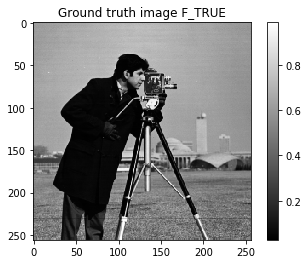

In [203]:
# Displaying in ground truth image
F_TRUE = mpimg.imread('Cameraman256.png')
N, M = F_TRUE.shape
imgplot = plt.imshow(F_TRUE,cmap='gray')
plt.colorbar()
plt.title('Ground truth image F_TRUE')
plt.savefig('./images/Cameraman256.png')
plt.show() 

## b.)
Set up a convolution mapping: Convolution can be done explicitly by setting up a matrix
$A$ as we have done in the last coursework for 1D. This takes far too much memory in 2D.
Instead write a function that takes in an image $f$ and outputs the blurred image $Af$.
> In the cell below we define the blurring function imblur, with which we will use the fixed SIGMA value for the rest of the experiments

In [204]:
# Defining blurring function for a given sigma
def imblur(f):
    return scipy.ndimage.filters.gaussian_filter(f, SIGMA)

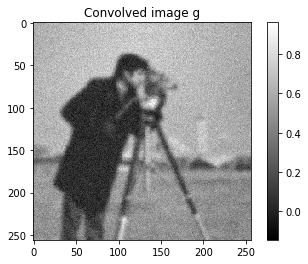

In [205]:
# Convolving image and adding noise
g = imblur(F_TRUE) + THETA*np.random.randn(N,N)
imgplot = plt.imshow(g,cmap='gray')
plt.colorbar()
plt.title('Convolved image g')
plt.savefig('./images/Cameraman256_convolved_noise.png')
plt.show()

## c.)
Deconvolve using normal equations, i.e. find $f_\alpha$ as the solution to
\begin{equation}
    (A^TA + \alpha I)f_\alpha = A^Tg:
\end{equation}
You can solve the above problem using a Krylov solver such as preconditioned conjugate
gradients (PCG) or GMRES.

In [206]:
# Helper class to count gmres iterations
class gmres_counter(object):
    def __init__(self):
        self.niter = 0
    def __call__(self, rk=None):
        self.niter += 1

Below we define a function **ATA_I** that computes $(A^TA + \alpha I)f$, exploiting the fact that the convolution is symmetric, i.e. $A^T = A$

In [207]:
ATA_I = lambda f, alpha: imblur(imblur(f.reshape((N,N)))) + alpha*(f.reshape((N,N)))

Below we use the **GMRES** solver, which we pass the sparse linear operator representation of **ATA_I**

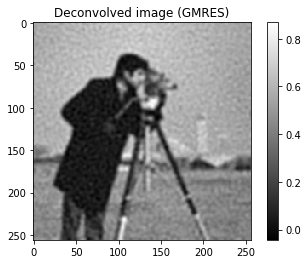

total number of iterations: 13
alpha value: 0.1


In [208]:
# counter to count number of iterations
counter = gmres_counter()

# GMRES method to solve Ax = b
def gmres_solution(_alpha, operator):
    
    A = scipy.sparse.linalg.LinearOperator((N*N,N*N), partial(operator, alpha = _alpha))
    ATg = imblur(g).reshape(N*N, 1)
    gmresOutput = scipy.sparse.linalg.gmres(A, ATg,  callback=counter, tol=1e-05)
    
    return gmresOutput

f_recon = gmres_solution(ALPHA, ATA_I)[0]
imgplot = plt.imshow(f_recon.reshape((N,N)),cmap='gray')
plt.colorbar()
plt.title('Deconvolved image (GMRES)')
plt.savefig('./images/Cameraman256_deconvolved.png')
plt.show()
print('total number of iterations: {}'.format(counter.niter))
print('alpha value: {}'.format(ALPHA))

## d.)
Rather than using the normal equations, numerical analysis suggests that it is preferable
to solve the augmented equations
\begin{equation}
\begin{pmatrix} 
A \\
\sqrt \alpha I 
\end{pmatrix}f
= 
\begin{pmatrix} 
g \\
0
\end{pmatrix}
\end{equation}
which can be done by a least squares solver (lsqr). Compare the performance to the one
you used in c.), in terms of number of iterations required to achieve convergence.

In [209]:
def M_f(f, alpha):
    x = imblur(f.reshape((N,N))).reshape((N*N,1))
    y = np.sqrt(alpha)*f.reshape((N*N,1))
    return np.vstack((x, y))

In [210]:
def MT_b(f, alpha):
    mid = f.size//2
    x = imblur(f[:mid].reshape((N,N))).reshape((N*N,1))
    y = np.sqrt(alpha)*f[mid:].reshape((N*N,1))
    return x + y

In [211]:
b = np.vstack([np.reshape(g,(g.size,1)),np.zeros((g.size,1))])
M = scipy.sparse.linalg.LinearOperator((2*N*N,N*N), matvec = partial(M_f, alpha = ALPHA),
                                       rmatvec = partial(MT_b, alpha = ALPHA))
f_alpha = lsqrOutput = scipy.sparse.linalg.lsqr(M,b, atol=1e-05, btol=1e-05)

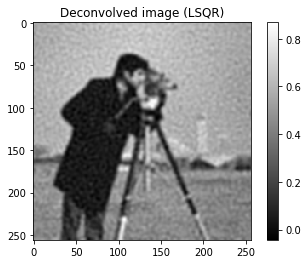

In [212]:
plt.imshow((f_alpha[0].reshape(N,N)), cmap='gray')
plt.title('Deconvolved image (LSQR)')
plt.colorbar()
plt.savefig('./images/Cameraman256_deconvolved_LSQR.png')
plt.show()

In [213]:
print('total number of iterations: {}'.format(f_alpha[2]))
print('sigma value: {}'.format(SIGMA))
print('theta value: {}'.format(THETA))
print('alpha value: {}'.format(ALPHA))

total number of iterations: 14
sigma value: 2.0
theta value: 0.05
alpha value: 0.1


***

# Question 2. Choose regularistion parameter $\alpha$

## i.)

In [214]:
def DP(alpha, operator):
    f_alpha = gmres_solution(alpha, operator)[0].reshape(N,N)
    r_alpha = (1/g.size)*np.linalg.norm(g.flatten() - imblur(f_alpha).flatten())**2 - THETA**2
    return r_alpha

In [215]:
dp_solution = scipy.optimize.root(partial(DP, operator=ATA_I), 0.1)
print('Discrepancy princple root: {}'.format(dp_solution.x[0]))

Discrepancy princple root: 0.029005418211545002


In [216]:
alphas = np.linspace(dp_solution.x[0]/3,2*dp_solution.x[0],20)
vals = []
for a in alphas:
    vals.append(DP(a, ATA_I))

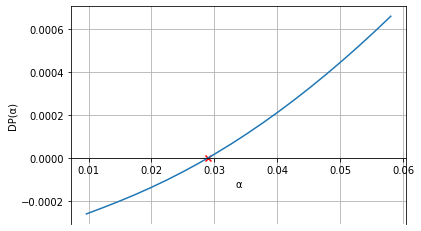

In [217]:
plt.plot(alphas, vals)
plt.gca().spines['bottom'].set_position('zero')
plt.scatter(dp_solution.x, 0, color='red', marker='x')
plt.grid()
plt.xlabel('\u03B1')
plt.ylabel('DP(\u03B1)')
plt.savefig('./images/DiscrepancyPrinciple.png')
plt.show()

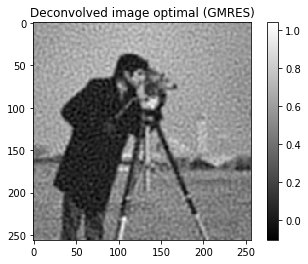

In [218]:
gmresOutput_optimal = gmres_solution(dp_solution.x[0], ATA_I)
imgplot = plt.imshow(gmresOutput_optimal[0].reshape((N,N)),cmap='gray')
plt.colorbar()
plt.title('Deconvolved image optimal (GMRES)')
plt.savefig('./images/Cameraman256_deconvolved_optimal.png')
plt.show()

## ii.)

In [219]:
#alphas = np.linspace(0.001,0.1,40)
alphas = 10**(np.linspace(-3, -1, 40))
llhd = np.zeros(alphas.size)
pr = np.zeros(alphas.size)
for i, a in enumerate(alphas):
    f_alpha = gmres_solution(a, ATA_I)[0].reshape(N,N)
    llhd[i] = np.linalg.norm(g.flatten() - imblur(f_alpha).flatten())**2
    pr[i] = np.linalg.norm(f_alpha.flatten())**2

In [220]:
gmres_llhd = np.linalg.norm(g.flatten() - imblur(gmresOutput_optimal[0].reshape((N,N))).flatten())**2
gmres_pr = np.linalg.norm(gmresOutput_optimal[0].flatten())**2

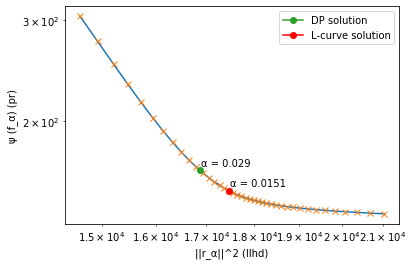

In [221]:
fig, ax = plt.subplots()
plt.loglog(pr, llhd)
plt.loglog(pr, llhd, marker = 'x', ls = '')
plt.loglog(gmres_pr, gmres_llhd, marker = 'o', label='DP solution')
ax.loglog(pr[23], llhd[23], marker = 'o', c='red', label='L-curve solution')
ax.annotate('\u03B1 = {0:.3g}'.format(alphas[23]), (pr[23]+30, llhd[23]+3))
ax.annotate('\u03B1 = {0:.3g}'.format(dp_solution.x[0]), (gmres_pr + 30, gmres_llhd+3))
plt.legend()
plt.xlabel('||r_\u03B1||^2 (llhd)')
plt.ylabel('\u03C8 (f_\u03B1) (pr)')
plt.savefig('./images/L-curve.png')
plt.show()

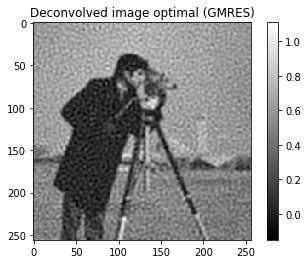

In [222]:
gmresOutput_optimal = gmres_solution(alphas[23], ATA_I)
imgplot = plt.imshow(gmresOutput_optimal[0].reshape((N,N)),cmap='gray')
plt.colorbar()
plt.title('Deconvolved image optimal (GMRES)')
plt.savefig('./images/Cameraman256_deconvolved_optimal_2.png')
plt.show()

# Question 3. Using a regularisation term based on the spatial derivative

## a.)

In [244]:
# Forming gradient operator sparse matrix
oneN = np.ones((N))
x = np.vstack((-oneN, oneN))
D1 = spdiags(x, [0, 1], N, N)
D1 = scipy.sparse.lil_matrix(D1)
D1[-1,:] = 0
D1y2d = kron(D1, eye(N))
D1x2d = kron(eye(N), D1)

In [239]:
D2 = spdiags(x, [0,1], 3,3)
D2 = scipy.sparse.lil_matrix(D2)
D2[-1,:] = 0

In [240]:
print(D2.toarray())

[[-1.  1.  0.]
 [ 0. -1.  1.]
 [ 0.  0.  0.]]


In [243]:
print(kron(eye(3), D2).toarray())

[[-1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.]]


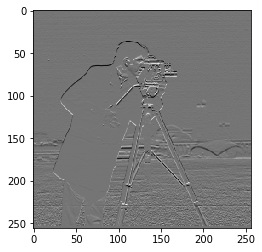

In [245]:
plt.imshow((D1 @ F_TRUE), cmap = 'gray')
plt.show()

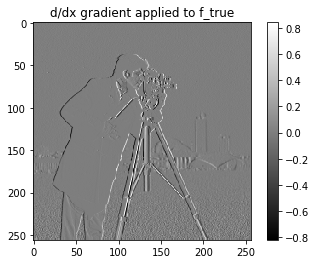

In [246]:
plt.imshow((D1x2d @ F_TRUE.reshape(N*N,1)).reshape(N,N), cmap='gray')
plt.colorbar()
plt.title('d/dx gradient applied to f_true')
plt.savefig('./images/grad_dx.png')
plt.show()

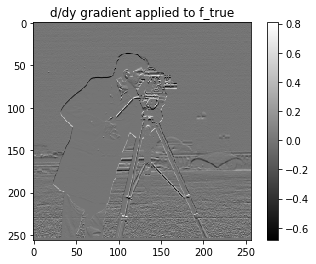

In [27]:
plt.imshow((D1y2d @ F_TRUE.reshape(N*N,1)).reshape(N,N), cmap='gray')
plt.colorbar()
plt.title('d/dy gradient applied to f_true')
plt.savefig('./images/grad_dy.png')
plt.show()

In [28]:
grad_op = vstack((D1x2d, D1y2d))

## b.)

In [29]:
# GMRES solution
ATA_DTD = lambda f, alpha: imblur(imblur(f.reshape((N,N)))) + 2*alpha*(grad_op.T @ grad_op @ f.reshape(N*N,1)).reshape(N,N)
f_alpha = gmres_solution(ALPHA, ATA_DTD)

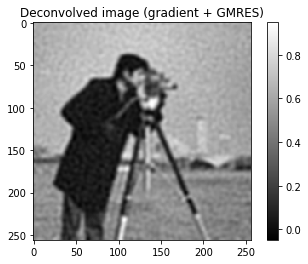

In [30]:
imgplot = plt.imshow(f_alpha[0].reshape((N,N)),cmap='gray')
plt.colorbar()
plt.title('Deconvolved image (gradient + GMRES)')
plt.savefig('./images/Cameraman256_deconvolved_grad_gmres.png')
plt.show()

In [31]:
# LSQR solution
def M_f_grad(f, alpha):
    x = imblur(f.reshape((N,N))).reshape((N*N,1))
    y = np.sqrt(alpha)*(grad_op @ f.reshape(N*N,1))
    return np.vstack((x, y))

def MT_b_grad(b, alpha):
    mid = b.size//3
    x = imblur(b[:mid].reshape((N,N))).reshape((N*N,1))
    y = np.sqrt(alpha)*(grad_op.T @ b[mid:].reshape(2*N*N,1))
    return x + y

In [32]:
b = np.vstack([np.reshape(g,(g.size,1)),np.zeros((g.size,1)), np.zeros((g.size,1))]) 
M = scipy.sparse.linalg.LinearOperator((3*N*N,N*N), matvec = partial(M_f_grad, alpha = ALPHA),
                                       rmatvec = partial(MT_b_grad, alpha = ALPHA))
f_alpha = scipy.sparse.linalg.lsqr(M,b)

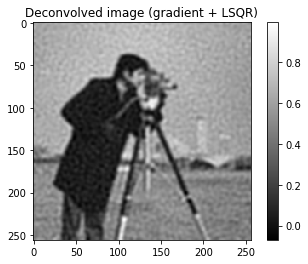

In [33]:
imgplot = plt.imshow(f_alpha[0].reshape((N,N)),cmap='gray')
plt.colorbar()
plt.title('Deconvolved image (gradient + LSQR)')
plt.savefig('./images/Cameraman256_deconvolved_grad_LSQR.png')
plt.show()

## c.)

In [34]:
dp_solution_grad = scipy.optimize.root(partial(DP, operator=ATA_DTD), 0.1)
print('Discrepancy princple root: {}'.format(dp_solution_grad.x[0]))

Discrepancy princple root: 0.1743243591109529


In [35]:
alphas_grad = np.linspace(dp_solution_grad.x[0]/3,2*dp_solution_grad.x[0],20)
vals_grad = []
for a in alphas_grad:
    vals_grad.append(DP(a, ATA_DTD))

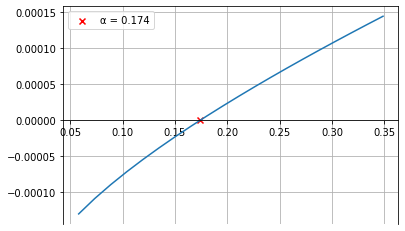

In [36]:
plt.plot(alphas_grad, vals_grad)
plt.gca().spines['bottom'].set_position('zero')
plt.scatter(dp_solution_grad.x, 0, color='red', marker='x', label='\u03B1 = {0:.3g}'.format(dp_solution_grad.x[0]))
plt.grid()
plt.legend()
plt.savefig('./images/DiscrepancyPrinciple_grad.png')
plt.show()

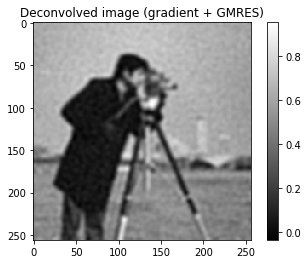

In [37]:
f_alpha = gmres_solution(dp_solution_grad.x[0], ATA_DTD)
imgplot = plt.imshow(f_alpha[0].reshape((N,N)),cmap='gray')
plt.colorbar()
plt.title('Deconvolved image (gradient + GMRES)')
plt.savefig('./images/Cameraman256_deconvolved_grad_optimal.png')
plt.show()

# Question 4. Construct an anisotropic derivative filter

In [118]:
#T = np.linalg.norm(grad_op @ g.reshape(N*N,1))*2
#T = 1
def gamma(f):
   # T = np.linalg.norm(grad_op @ f.reshape(N*N,1))*2
    T = np.max(abs(grad_op @ f.reshape(N*N,1)))*0.2
    return np.exp(-np.sqrt((D1x2d @ f.reshape(N*N,1))**2 + (D1y2d @ f.reshape(N*N,1))**2)/T)

perona_malik_filter = spdiags((gamma(g).flatten()), [0], N*N, N*N)
anisotropic_filter = vstack((np.sqrt(perona_malik_filter) * D1x2d, np.sqrt(perona_malik_filter) * D1y2d))

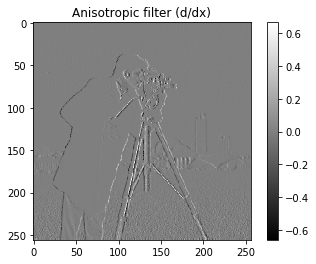

In [119]:
plt.imshow((np.sqrt(perona_malik_filter) * D1x2d @ F_TRUE.reshape(N*N,1)).reshape(N,N), cmap='gray')
plt.colorbar()
plt.title('Anisotropic filter (d/dx)')
plt.savefig('./images/aniso_dx.png')
plt.show()

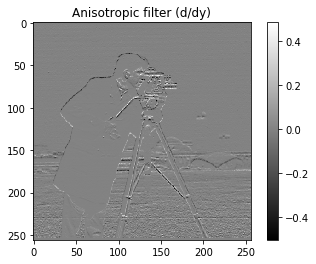

In [120]:
plt.imshow((np.sqrt(perona_malik_filter) * D1y2d @ F_TRUE.reshape(N*N,1)).reshape(N,N), cmap='gray')
plt.colorbar()
plt.title('Anisotropic filter (d/dy)')
plt.savefig('./images/aniso_dy.png')
plt.show()

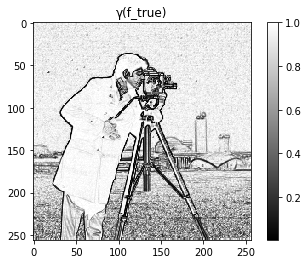

In [121]:
plt.imshow(gamma(F_TRUE).reshape((N,N)), cmap='gray')
plt.title('\u03B3(f_true)')
plt.colorbar()
plt.savefig('./images/gamma_f.png')
plt.show()

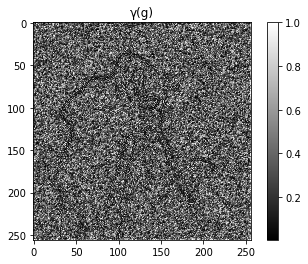

In [122]:
plt.imshow(gamma(g).reshape((N,N)), cmap='gray')
plt.title('\u03B3(g)')
plt.colorbar()
plt.savefig('./images/gamma_g.png')
plt.show()

In [123]:
ATA_G_DTD = lambda f, alpha, filt: imblur(imblur(f.reshape((N,N)))) \
    + alpha*(filt.T @ filt @ f.reshape(N*N,1)).reshape(N,N)

In [124]:
counter = gmres_counter()
def gmres_solution_filter(alp, opfilter, operator):
    curr_filter = partial(ATA_G_DTD, alpha = alp, filt = opfilter)
    A = scipy.sparse.linalg.LinearOperator((N*N,N*N), curr_filter)
    ATg = imblur(g).reshape(N*N, 1)
    gmresOutput = scipy.sparse.linalg.gmres(A, ATg, callback = counter)
    return gmresOutput[0]

In [125]:
gmres_aniso_solution = gmres_solution_filter(ALPHA, anisotropic_filter, ATA_G_DTD)

26


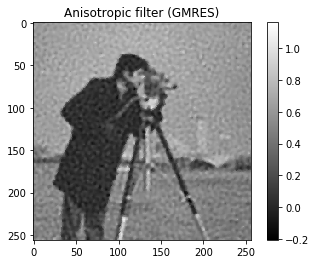

In [126]:
print(counter.niter)
plt.imshow((gmres_aniso_solution).reshape(N,N), cmap='gray')
plt.colorbar()
plt.title('Anisotropic filter (GMRES)')
plt.savefig('./images/aniso_gmres.png')
plt.show()

200.80060047819245


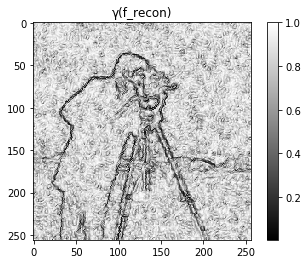

In [127]:
plt.imshow(gamma(gmres_aniso_solution.reshape(N,N)).reshape((N,N)), cmap='gray')
print(np.linalg.norm(gamma(gmres_aniso_solution)))
plt.colorbar()
plt.title('\u03B3(f_recon)')
plt.savefig('./images/aniso_gmres_gamma.png')
plt.show()

In [128]:
print(np.linalg.norm(gamma(g)))

108.32908942525609


# 5. Iterative deblurring

In [285]:

def iterative_deblur(g, alp):
    
    fig, ax = plt.subplots(2, 6, figsize=(30,10), sharex=True)
    fig.tight_layout()
    f_i = np.copy(g)
    diff = 0 
    alp = 0.2
    
    for i in range(6):
        #print(np.linalg.norm(gamma(f_i)))
        # display output
       # ax[0].title('test')
        ax[0,i].imshow(f_i, cmap='gray')
        ax[1,i].imshow(gamma(f_i).reshape((N,N)), cmap='gray')
        ax[0,i].set_title('f_recon, iteration = {}'.format(i))
        ax[1,i].set_title('diffusivity, iteration = {}'.format(i))
        
        # constuct matrix (ATA + 2*alpha*D^T gamma D)
        perona_i = spdiags((gamma(f_i).flatten()), [0], N*N, N*N)
        filter_i = vstack((np.sqrt(perona_i) * D1x2d, np.sqrt(perona_i) * D1y2d))
        curr_filter = partial(ATA_G_DTD, alpha = alp, filt = filter_i)
        
        A = scipy.sparse.linalg.LinearOperator((N*N,N*N), curr_filter)
        ATg = imblur(g).reshape(N*N, 1)

        f_i = scipy.sparse.linalg.gmres(A, ATg)[0].reshape((N,N))
        print(np.linalg.norm(imblur(f_i) - g))
    plt.savefig('./images/iterative_deblur.png')

12.272272440409182
12.391628925600482
12.426520211959952
12.432493759709342
12.433720119515025
12.43389557403334


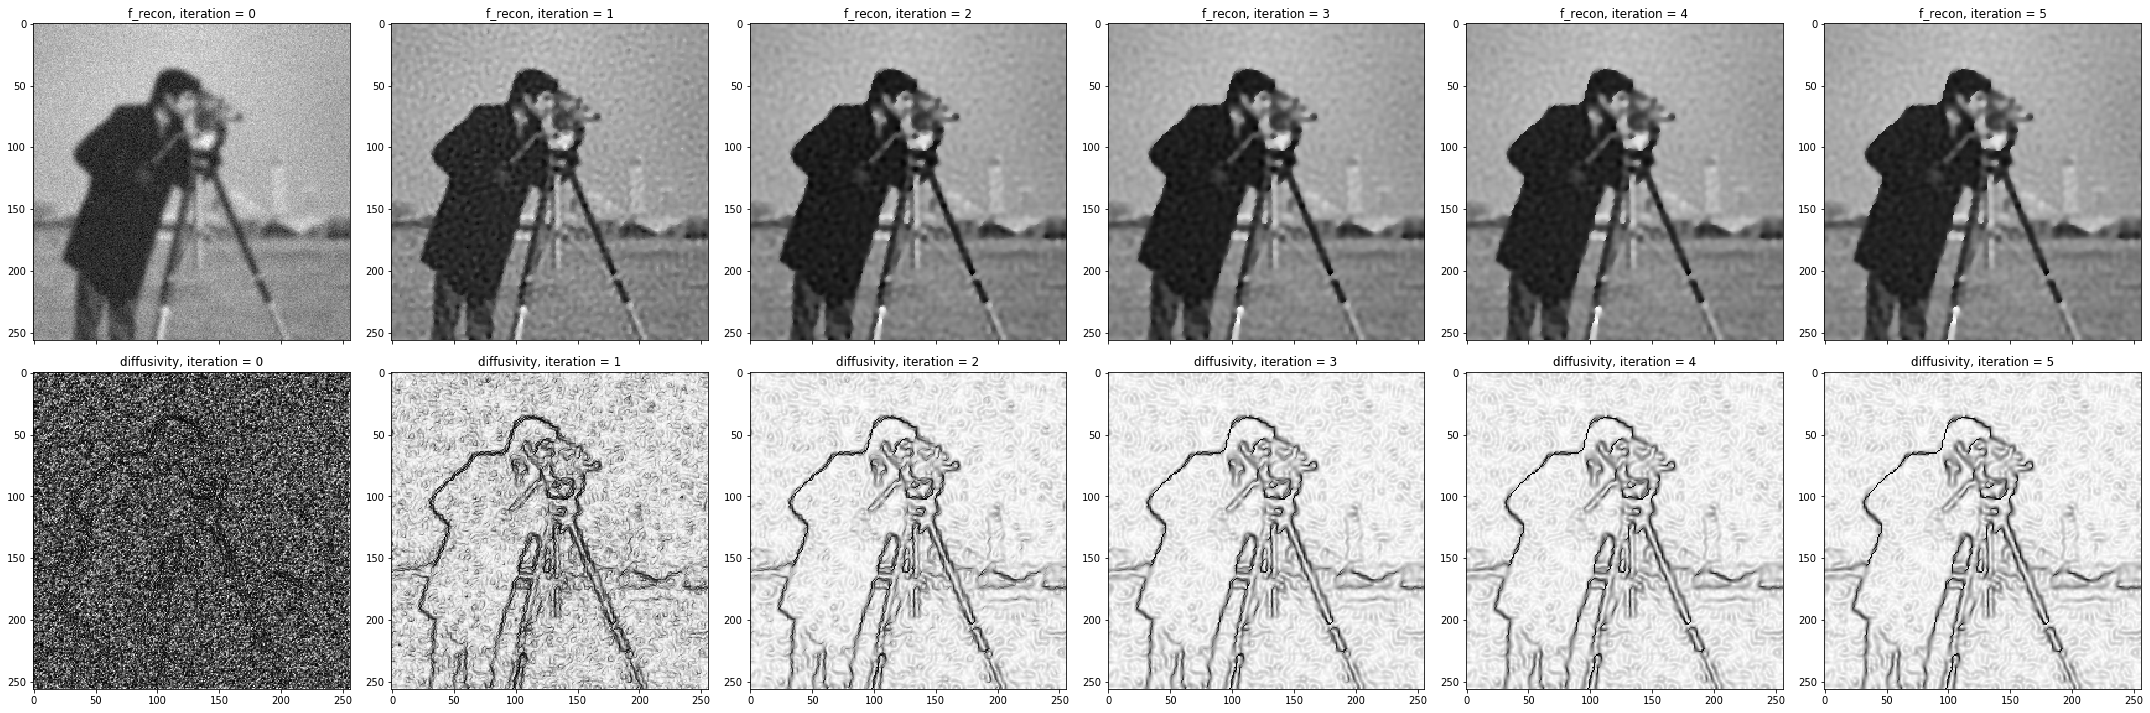

In [286]:
iterative_deblur(g, 0.15)